In [215]:
import os
import random
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from torchvision.models import densenet121, DenseNet121_Weights
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
from PIL import Image
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import cv2
import matplotlib.pyplot as plt

Create an image dataset class:

In [216]:
class ImageDataset(Dataset):
    def __init__(self, img_dir, csv_file, transform=None):
        
        self.img_dir = img_dir
        self.image_paths = []
        self.labels = []
        self.transform = transform


        self.lables_genres = dict()

        df_genres = pd.read_csv(csv_file)
        self.lables_genres = dict(zip(df_genres["id"], df_genres["label"]))

        self.n_labels = len(self.lables_genres)

        for label_name in os.listdir(img_dir):  
            label_path = os.path.join(img_dir, label_name)
            if os.path.isdir(label_path):
                for img_name in os.listdir(label_path):
                    self.image_paths.append(os.path.join(label_path, img_name))
                    self.labels.append(label_name)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)
        
        label = torch.tensor(int(label), dtype=torch.long) 

        return image, label


In [217]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.08, 1.0), ratio=(3/4, 4/3)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [218]:
train_dataset = ImageDataset("dataset/train", "labels.csv", transform=train_transform)
val_dataset = ImageDataset("dataset/validation", "labels.csv", transform=test_transform)
test_dataset = ImageDataset("dataset/test", "labels.csv", transform=test_transform)

In [219]:
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True) 
val_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=False) 
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=False) 

In [220]:
weights = DenseNet121_Weights.DEFAULT 
GenRe = models.densenet121(weights=weights)

for param in GenRe.parameters(): 
    param.requires_grad = False

for param in GenRe.features.denseblock4.parameters():
    param.requires_grad = True

for param in GenRe.features.norm5.parameters():
    param.requires_grad = True

n_features = GenRe.classifier.in_features 
n_classes = train_dataset.n_labels  
GenRe.classifier = nn.Linear(n_features, n_classes) 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
GenRe = GenRe.to(device)

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, GenRe.parameters()),
    lr=1e-4
)

train_losses = []
val_losses = []

def train_model(model, train_loader, val_loader, loss_function, optimizer, num_epochs=20, patience=5):
    
    best_val_loss = float('inf')
    epochs_no_improve = 0
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_classifications = 0
        total_classifications = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = loss_function(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_classifications += labels.size(0) 
            correct_classifications += (predicted == labels).sum().item()
        
        train_loss = running_loss / len(train_loader) 
        train_losses.append(train_loss) 
        train_accuracy = 100 * correct_classifications / total_classifications    

        model.eval() 
        val_loss = 0.0 
        val_correct_classifications = 0 
        val_total_classifications = 0

        with torch.no_grad(): 
            for images, labels in val_loader: 
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = loss_function(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total_classifications += labels.size(0)
                val_correct_classifications += (predicted == labels).sum().item()

        val_loss /= len(val_loader) 
        val_losses.append(val_loss)  
        val_accuracy = 100 * val_correct_classifications / val_total_classifications
         
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), 'models/best_GenRe_model.pt')
        else:
            epochs_no_improve += 1
        
        
        print(f"Epoch [{epoch+1}/{num_epochs}], " 
            f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, " 
            f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%") 

        if epochs_no_improve >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break 

train_model(GenRe, train_dataloader, val_dataloader, loss_function, optimizer, num_epochs=20, patience=5) 

Epoch [1/20], Train Loss: 0.7170, Train Accuracy: 73.27%, Val Loss: 0.3877, Val Accuracy: 87.67%
Epoch [2/20], Train Loss: 0.6365, Train Accuracy: 77.27%, Val Loss: 0.3846, Val Accuracy: 87.17%
Epoch [3/20], Train Loss: 0.6015, Train Accuracy: 79.23%, Val Loss: 0.3543, Val Accuracy: 87.33%
Epoch [4/20], Train Loss: 0.5722, Train Accuracy: 79.86%, Val Loss: 0.3578, Val Accuracy: 87.83%
Epoch [5/20], Train Loss: 0.5473, Train Accuracy: 80.86%, Val Loss: 0.3489, Val Accuracy: 88.92%
Epoch [6/20], Train Loss: 0.5332, Train Accuracy: 81.52%, Val Loss: 0.3374, Val Accuracy: 89.17%
Epoch [7/20], Train Loss: 0.5404, Train Accuracy: 81.79%, Val Loss: 0.3567, Val Accuracy: 88.42%
Epoch [8/20], Train Loss: 0.5047, Train Accuracy: 82.80%, Val Loss: 0.3548, Val Accuracy: 88.00%
Epoch [9/20], Train Loss: 0.4960, Train Accuracy: 83.30%, Val Loss: 0.3685, Val Accuracy: 87.50%
Epoch [10/20], Train Loss: 0.4847, Train Accuracy: 83.46%, Val Loss: 0.3629, Val Accuracy: 87.42%
Epoch [11/20], Train Loss: 0.

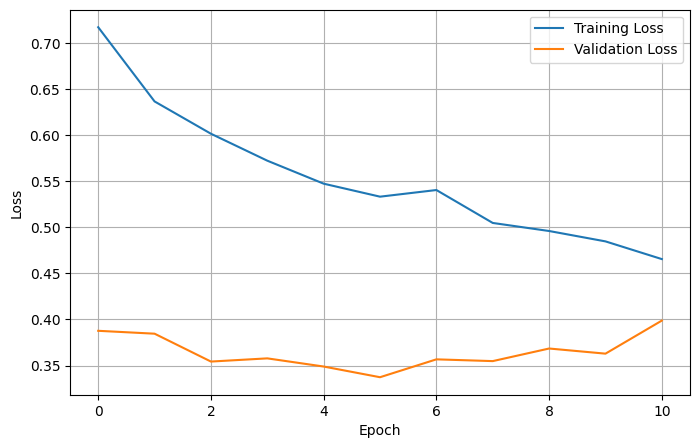

In [221]:
plt.figure(figsize=(8,5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [222]:
weights = DenseNet121_Weights.DEFAULT
GenRe = densenet121(weights=weights)

n_classes = train_dataset.n_labels
GenRe.classifier = nn.Linear(GenRe.classifier.in_features, n_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
state_dict = torch.load("models/best_GenRe_model.pt", map_location=device)
GenRe.load_state_dict(state_dict)

GenRe = GenRe.to(device)
GenRe.eval()

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

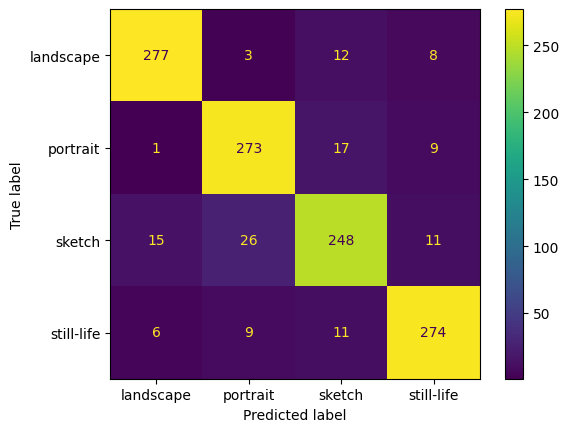

{'Accuracy': 0.8933333333333333, 'Precision': 0.8931576972071142, 'Sensitivity_recall': 0.8933333333333333, 'F1_score': 0.8930820577209265}


In [223]:
true_labels_list = []
predicted_labels_list = []

GenRe.eval()
for images, true_labels in test_dataloader:
    images, true_labels = images.to(device), true_labels.to(device)
    with torch.no_grad():
        outputs = GenRe(images)
        _, predictions = torch.max(outputs, 1)
        true_labels_list.extend(true_labels.cpu().numpy())
        predicted_labels_list.extend(predictions.cpu().numpy())

#Confusion matrix
display_labels = []
for idx in range(test_dataset.n_labels):
    display_label = test_dataset.lables_genres[idx]
    display_labels.append(display_label)

cm = confusion_matrix(true_labels_list, predicted_labels_list)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = display_labels)
cm_display.plot()
plt.show()

#Metrics
accuracy = accuracy_score(true_labels_list, predicted_labels_list)
precision = precision_score(true_labels_list, predicted_labels_list, average="macro")
recall = recall_score(true_labels_list, predicted_labels_list, average="macro")
F1_score = f1_score(true_labels_list, predicted_labels_list, average="macro")

print({"Accuracy":accuracy,"Precision":precision,"Sensitivity_recall":recall,"F1_score":F1_score})

In [224]:
weights = DenseNet121_Weights.DEFAULT 
baseline_model = models.densenet121(weights=weights)

features_extractor = nn.Sequential(
    baseline_model.features,
    nn.ReLU(inplace=True),
    nn.AdaptiveAvgPool2d((1, 1))
)

features_extractor.eval()
features_extractor.to(device)

def features_extraction (dataloader):
    features = [] 
    true_labels = []

    with torch.no_grad(): 
        for image, label in dataloader: 
            image = image.to(device) 

            feats = features_extractor(image)  
            feats = feats.view(feats.size(0), -1)

            features.append(feats.cpu()) 
            true_labels.extend(label.cpu().numpy())
    
    features_matrix = torch.cat(features, dim=0) 
    
    return features_matrix, true_labels

features_matrix_train, true_labels_train = features_extraction(train_dataloader)
features_matrix_val, true_labels_val = features_extraction(val_dataloader) 
features_matrix_test, true_labels_test = features_extraction(test_dataloader)  

In [225]:
best_k = None
best_acc = 0
results = dict()

for k in [1, 3, 5, 7, 9]:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(features_matrix_train, true_labels_train)          
    predicted_labels_val = knn.predict(features_matrix_val)    
    acc = accuracy_score(true_labels_val, predicted_labels_val)

    results[k] = acc

    if acc > best_acc:
        best_acc = acc
        best_k = k

print("Validation results:", results)
print(f"Best k = {best_k} with accuracy = {best_acc:.4f}")

Validation results: {1: 0.8258333333333333, 3: 0.8525, 5: 0.8575, 7: 0.8691666666666666, 9: 0.8691666666666666}
Best k = 7 with accuracy = 0.8692


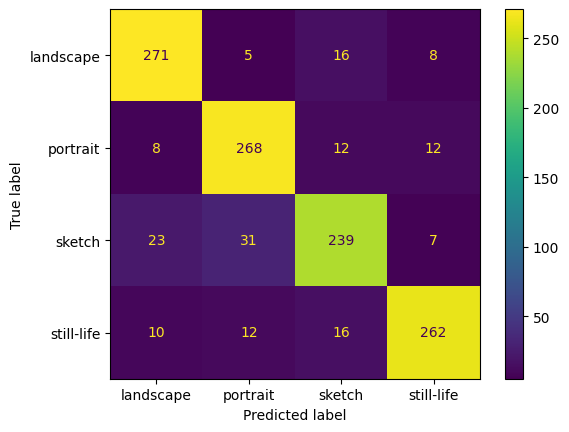

{'Accuracy': 0.8666666666666667, 'Precision': 0.866947093018519, 'Sensitivity_recall': 0.8666666666666667, 'F1_score': 0.8663228331770076}


In [226]:
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(features_matrix_train, true_labels_train)

predicted_labels_test = knn.predict(features_matrix_test)

display_labels = []
for idx in range(test_dataset.n_labels):
    display_label = test_dataset.lables_genres[idx]
    display_labels.append(display_label)

cm = confusion_matrix(true_labels_test, predicted_labels_test)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = display_labels)
cm_display.plot()
plt.show()

knn_accuracy = accuracy_score(true_labels_test, predicted_labels_test)
knn_precision = precision_score(true_labels_test, predicted_labels_test, average="macro")
knn_recall = recall_score(true_labels_test, predicted_labels_test, average="macro")
knn_F1_score = f1_score(true_labels_test, predicted_labels_test, average="macro")

print({"Accuracy":knn_accuracy,"Precision":knn_precision,"Sensitivity_recall":knn_recall,"F1_score":knn_F1_score})


In [227]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.activations = None
        self.gradients = None
        
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()

        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0].detach()

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate(self, img_tensor, class_idx=None):
        self.model.zero_grad()
        output = self.model(img_tensor)

        if class_idx is None:
            class_idx = output.argmax(dim=1).item()

        loss = output[:, class_idx]
        loss.backward()

        weights = self.gradients.mean(dim=(2, 3), keepdim=True)

        cam = (weights * self.activations).sum(dim=1)

        cam = torch.relu(cam)
        cam = cam[0].cpu().numpy()
        cam = cv2.resize(cam, (224, 224))
        cam = cam / cam.max()

        return cam

def show_gradcam_on_image(img, cam, model_name, pred_label_str, alpha=0.4):
    img = cv2.resize(img, (224, 224))

    heatmap = plt.cm.jet(cam)[:, :, :3] 
    overlay = (1 - alpha) * img + alpha * heatmap

    plt.figure(figsize=(5,5))
    plt.imshow(overlay)
    plt.title(f"GradCAM of {model_name}'s features\nPredicted genre: {pred_label_str}")
    plt.axis("off")
    plt.show()


c:\Users\valen\anaconda3\envs\art-classifier\Lib\site-packages\torch\nn\modules\module.py:1842: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


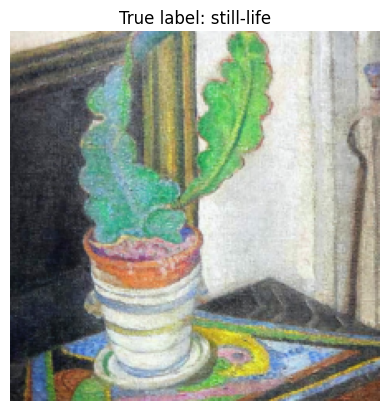

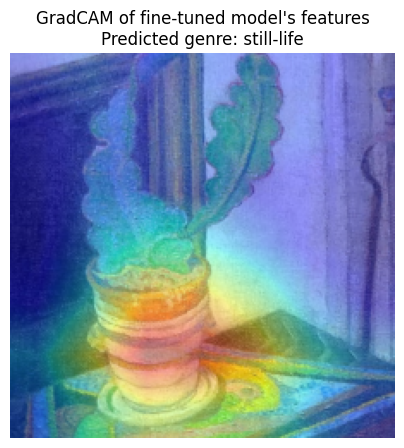

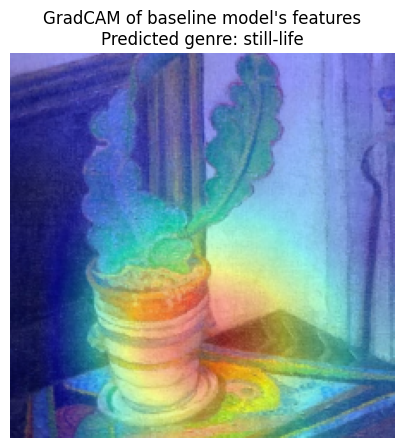

In [228]:
idx = random.randint(0, len(test_dataset) - 1)
image, true_label = test_dataset[idx]

image_batch = image.unsqueeze(0).to(device)
true_label_idx = true_label.item()
true_label_str = test_dataset.lables_genres[true_label_idx]

GenRe.eval()
with torch.no_grad():
    outputs = GenRe(image_batch)
    probabilities = F.softmax(outputs, dim=1)
    _, pred_label = torch.max(probabilities, 1)

pred_label_ft = pred_label.item()
pred_label_ft_str = test_dataset.lables_genres[pred_label_ft]


baseline_model.eval()
with torch.no_grad():
    feats = features_extractor(image_batch)
    feats = feats.view(1, -1).cpu().numpy()

pred_label_knn = knn.predict(feats)[0]
pred_label_knn_str = test_dataset.lables_genres[pred_label_knn]


model_target_layer = GenRe.features.denseblock4
model_gradcam = GradCAM(GenRe, model_target_layer)
model_cam = model_gradcam.generate(image_batch)

baseline_target_layer = baseline_model.features.denseblock4
baseline_gradcam = GradCAM(baseline_model, baseline_target_layer)
baseline_cam = baseline_gradcam.generate(image_batch)

def denormalize(img):
    mean = torch.tensor([0.485, 0.456, 0.406])
    std = torch.tensor([0.229, 0.224, 0.225])
    img = img * std[:, None, None] + mean[:, None, None]
    return img.clamp(0, 1)

img = denormalize(image).cpu().permute(1, 2, 0).numpy()
plt.imshow(img)
plt.title(f"True label: {true_label_str}")
plt.axis("off")
plt.show()

show_gradcam_on_image(img, model_cam, "fine-tuned model", pred_label_ft_str)
show_gradcam_on_image(img, baseline_cam, "baseline model", pred_label_knn_str)